<a href="https://www.kaggle.com/code/mohamedatef20/speaker-recognition?scriptVersionId=154910180" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/tf_Wav_reader.py
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/611.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/364.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/367.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/116.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/1490.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/374.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/1359.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/485.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/456.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/626.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/590.

In [2]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
from scipy.io.wavfile import read
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# import matplotlib.pyplot as plt
# plt.plot(signal);

In [4]:
data_dir = "../input/speaker-recognition-dataset/16000_pcm_speeches/"
os.listdir(data_dir)

['Nelson_Mandela',
 'Benjamin_Netanyau',
 'other',
 '_background_noise_',
 'tf_Wav_reader.py',
 'Magaret_Tarcher',
 'Jens_Stoltenberg',
 'Julia_Gillard']

In [5]:
 nelson_madela= [item for item in os.listdir(data_dir + "Nelson_Mandela")]
nelson_madela[:10]

['611.wav',
 '364.wav',
 '367.wav',
 '116.wav',
 '1490.wav',
 '374.wav',
 '1359.wav',
 '485.wav',
 '456.wav',
 '626.wav']

# Plot audio

In [6]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot(speaker):
    data_dir = '/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/'
    speaker_path = os.path.join(data_dir, speaker)
    
    files = os.listdir(speaker_path)
    num_files = len(files)
    
    
    num_cols = 2
    num_rows = (num_files + num_cols - 1) // num_cols
    
    
    plt.figure(figsize=(15, 4 * num_rows))
    
    for i, item in enumerate(files, start=1):
        file_path = os.path.join(speaker_path, item)
        y, sr = librosa.load(file_path)
        
        # Create subplots
        plt.subplot(num_rows, num_cols, i)
        librosa.display.waveshow(y, sr=sr, alpha=0.5)
        
        plt.title(f'Waveform - {item}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()



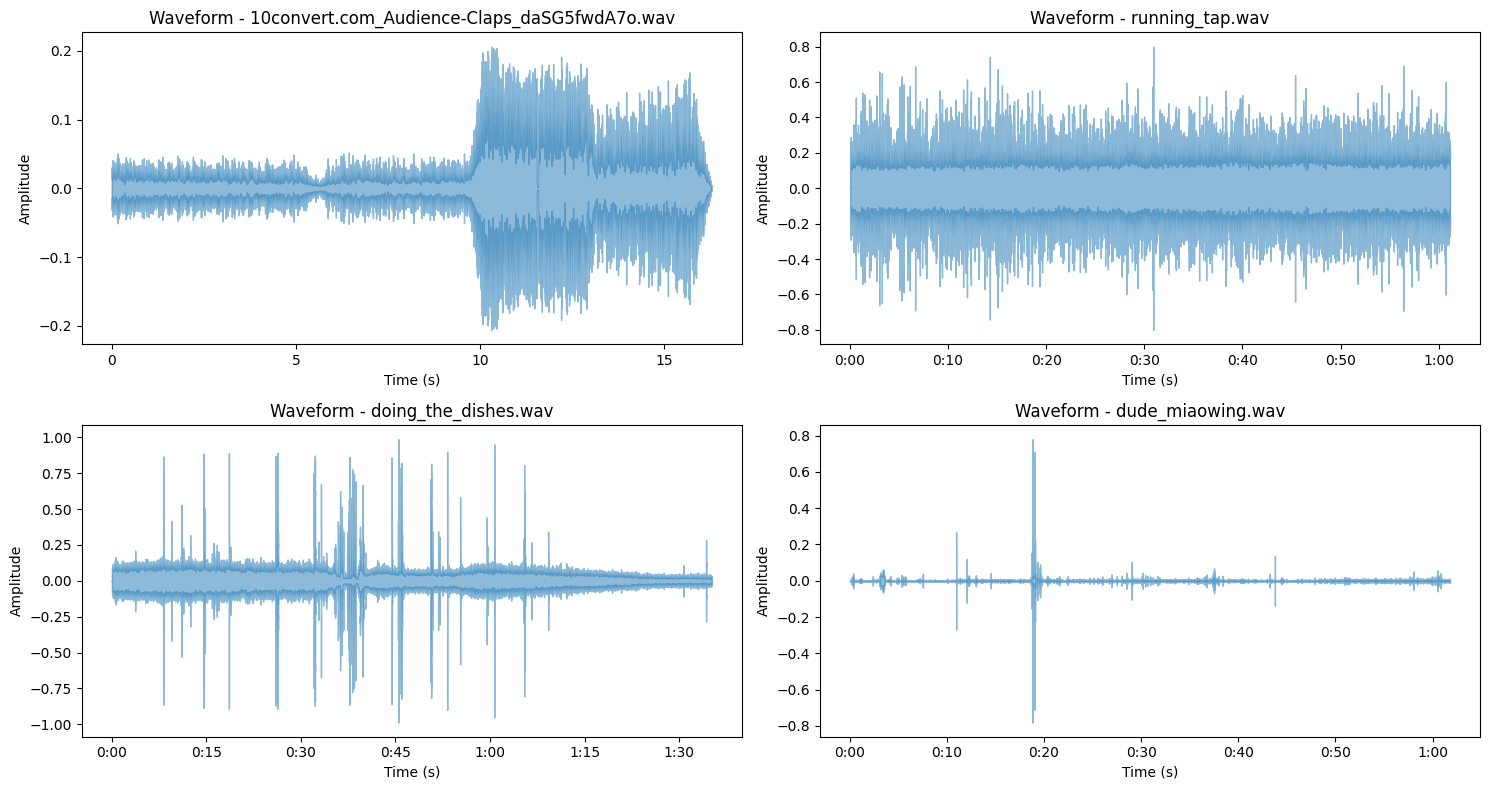

In [7]:
nelson_mandela_paths = plot("/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_")


##  Process training dataset


In [8]:
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [9]:
nelson_mandela_paths = get_wav_paths("Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( 'Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("Julia_Gillard")

In [10]:
import tensorflow as tf

def load_wav(wav_path, speaker):
    wav_path = data_dir + speaker + "/" + wav_path
    
    wav_data, _ = tf.audio.decode_wav(tf.io.read_file(wav_path), desired_channels=1)
    wav_data = tf.reshape(wav_data, [1, -1])
    return wav_data



# Additive White Gaussian Noise (AWGN)

In [11]:
def add_awgn(signal, snr_dB):
    # Calculate noise power
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_dB / 10.0))
    
    # Generate Gaussian noise
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    
    # Add noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

In [12]:
def generate_training_data(speaker_paths, speaker, label, snr_dB=15):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        # Add AWGN to the waveform
        noisy_wav = add_awgn(wav, snr_dB)
        wavs.append(noisy_wav)
        labels.append(label)
    return wavs, labels

In [13]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "Julia_Gillard", 4) 

100%|██████████| 1501/1501 [00:07<00:00, 201.29it/s]


In [14]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [15]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [16]:
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [17]:
test_x.shape

(1500, 1, 16000)

In [18]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [19]:
!pip install spela
from spela.spectrogram import Spectrogram 
from spela.melspectrogram import Melspectrogram

In [20]:
from keras.layers import Dense, BatchNormalization, Dropout


In [21]:
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(input_shape=(1, 16000)))
    elif speech_feature == "melspectrogram":
         model.add(Melspectrogram(input_shape=(1, 16000), name='melgram'))

    model.add(tf.keras.layers.Conv2D(265, (3, 3), activation="relu"))
    model.add(Dropout(0.5))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(5, 5)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

In [22]:
model = create_model("spectrogram")

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram (Spectrogram)   (None, 257, 63, 1)        263168    
                                                                 
 conv2d (Conv2D)             (None, 255, 61, 265)      2650      
                                                                 
 dropout (Dropout)           (None, 255, 61, 265)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 51, 12, 265)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 162180)            0         
                                                                 
 dense (Dense)               (None, 5)                 810905    
                                                        

In [24]:
history=model.fit(x=train_x, y=train_y, epochs=25, validation_data=(test_x, test_y))


Epoch 1/25


2023-12-13 20:57:45.444848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


188/188 [==============================] - 18s 51ms/step - loss: 22.1950 - accuracy: 0.7130 - val_loss: 0.4195 - val_accuracy: 0.8367
Epoch 2/25
188/188 [==============================] - 9s 47ms/step - loss: 0.2400 - accuracy: 0.9143 - val_loss: 0.3072 - val_accuracy: 0.8813
Epoch 3/25
188/188 [==============================] - 9s 47ms/step - loss: 0.1383 - accuracy: 0.9482 - val_loss: 0.2668 - val_accuracy: 0.9000
Epoch 4/25
188/188 [==============================] - 9s 47ms/step - loss: 0.1025 - accuracy: 0.9558 - val_loss: 0.2481 - val_accuracy: 0.9193
Epoch 5/25
188/188 [==============================] - 9s 47ms/step - loss: 0.0903 - accuracy: 0.9627 - val_loss: 0.2253 - val_accuracy: 0.9153
Epoch 6/25
188/188 [==============================] - 9s 48ms/step - loss: 0.0804 - accuracy: 0.9683 - val_loss: 0.2744 - val_accuracy: 0.9060
Epoch 7/25
188/188 [==============================] - 9s 47ms/step - loss: 0.0799 - accuracy: 0.9667 - val_loss: 0.2398 - val_accuracy: 0.9167
Epoch 8/

In [25]:
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"loss: {test_loss:0.3}\t accuracy: {test_accuracy:0.1%}")

47/47 [==============================] - 0s 6ms/step - loss: 0.2751 - accuracy: 0.9493
loss: 0.275	 accuracy: 94.9%


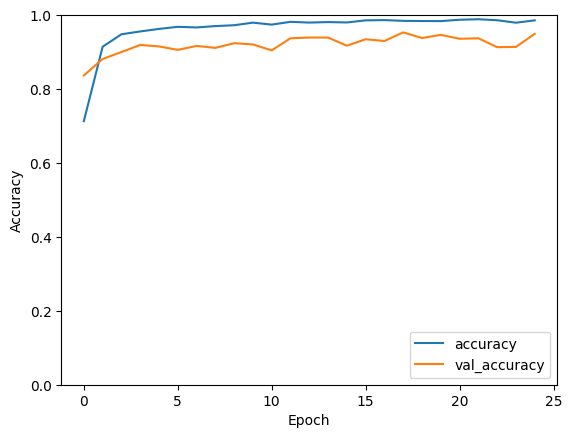

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

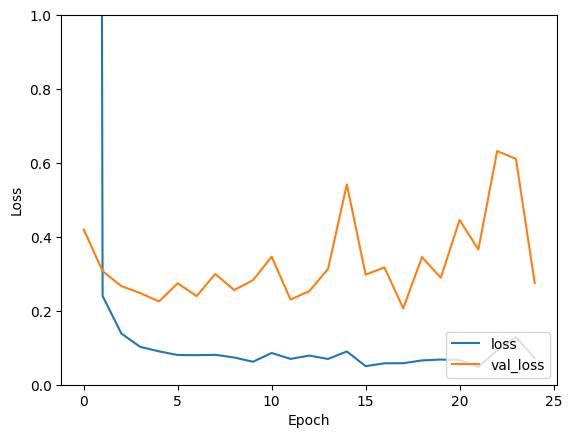

In [27]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show();

# Test the predication

In [28]:
train_x.shape

(6000, 1, 16000)

In [29]:
y_predication = model.predict(test_x)

47/47 [==============================] - 0s 5ms/step


In [30]:
y_predication[0]

array([0.0000000e+00, 0.0000000e+00, 6.2242226e-24, 5.5467693e-36,
       1.0000000e+00], dtype=float32)

In [31]:
predicted_label = np.argmax(y_predication[0])

In [32]:
predicted_label

4

In [33]:
test_x[10]

array([[ 0.04440015, -0.01745898, -0.15561205, ..., -0.27716357,
        -0.30301195, -0.36441332]], dtype=float32)

In [34]:
y_pred=[]
for  i in range(10):
    y_predication = model.predict(test_x)
    predicted_label = np.argmax(y_predication[i])
    y_pred.append(predicted_label)    

47/47 [==============================] - 0s 5ms/step


In [35]:
labels = np.argmax(test_y, axis=1)
pd.Series(labels)

0       4
1       3
2       1
3       1
4       3
       ..
1495    3
1496    2
1497    1
1498    0
1499    0
Length: 1500, dtype: int64

In [36]:
class_names = {0: "Nelson_Mandela", 1: "Magaret_Tarcher", 3: "Jens_Stoltenberg", 2: "Benjamin_Netanyau",4:'Julia_Gillard'}

for index in range(10):
        print(y_pred[index],
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index]:
            print("Welcome")
        else:
            print("Sorry")
        print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

4 Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard
3 Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
Welcome
The speaker is Jens_Stoltenberg
1 Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
1 Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
3 Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
Welcome
The speaker is Jens_Stoltenberg
3 Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
Welcome
The speaker is Jens_Stoltenberg
3 Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
Welcome
The speaker is Jens_Stoltenberg
2 Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
4 Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard
2 Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau


# Inference 

In [37]:
from pydub import AudioSegment
def convert_mp3_to_wav(input_path, output_path):
    audio = AudioSegment.from_mp3(input_path)
    audio.export(output_path, format="wav")



In [38]:
input_path2 = "/kaggle/input/final1/Voicy_ I think often insisting on.mp3"
output_path2 = "/kaggle/working/output2.wav"
input_path3 = "/kaggle/input/final1/Voicy_ I wanted to be clear (1).mp3"
output_path3 = "/kaggle/working/output3.wav"
input_path4 = "/kaggle/input/final1/Voicy_ I wanted to be clear.mp3"
output_path4 = "/kaggle/working/output4.wav"
input_path5 = "/kaggle/input/final1/Voicy_7 times a broken down.mp3"
output_path5 = "/kaggle/working/output5.wav"
input_path6 = "/kaggle/input/final1/Voicy_7 times a broken down.mp3"
output_path6 = "/kaggle/working/output6.wav"
input_path7 = "/kaggle/input/final1/Voicy_Between members of the staff.mp3"
output_path7 = "/kaggle/working/output7.wav"
input_path8 = "/kaggle/input/final1/Voicy_Straight forward negotiating (1).mp3"
output_path8 = "/kaggle/working/output8.wav"
input_path9 = "/kaggle/input/final1/Voicy_They have a cleverness  (1).mp3"
output_path9 = "/kaggle/working/output9.wav"
input_path10 = "/kaggle/input/final1/Voicy_They should bear success.mp3"
output_path10 = "/kaggle/working/output10.wav"

In [39]:
convert_mp3_to_wav(input_path2, output_path2)
convert_mp3_to_wav(input_path3, output_path3)
convert_mp3_to_wav(input_path4, output_path4)
convert_mp3_to_wav(input_path5, output_path5)
convert_mp3_to_wav(input_path6, output_path6)
convert_mp3_to_wav(input_path7, output_path7)
convert_mp3_to_wav(input_path8, output_path8)
convert_mp3_to_wav(input_path9, output_path9)
convert_mp3_to_wav(input_path10, output_path10)

In [40]:
import tensorflow as tf
import numpy as np

audio_arrays = []

file_paths = ["/kaggle/working/output2.wav", "/kaggle/working/output3.wav","/kaggle/working/output4.wav","/kaggle/working/output5.wav","/kaggle/working/output6.wav","/kaggle/working/output7.wav","/kaggle/working/output8.wav","/kaggle/working/output9.wav","/kaggle/working/output10.wav"]

for file_path in file_paths:
    wav_data, _ = tf.audio.decode_wav(tf.io.read_file(file_path), desired_channels=1, desired_samples=16000)
    reshaped_array = tf.reshape(wav_data, [1, 1, 16000])
#     reshaped_array=add_awgn(reshaped_array,15)
    audio_arrays.append(reshaped_array)
audio_data_array = np.concatenate(audio_arrays, axis=0)

print("Shape of the resulting array:", audio_data_array.shape)

        

Shape of the resulting array: (9, 1, 16000)


In [41]:
audio_data_array.shape

(9, 1, 16000)

In [42]:
y_pred=[]
for  i in range(9):
    y_predication = model.predict(test_x)
    predicted_label = np.argmax(y_predication[i])
    y_pred.append(predicted_label)
    print(class_names[y_pred[i]],predicted_label)

47/47 [==============================] - 0s 5ms/step
Julia_Gillard 4
47/47 [==============================] - 0s 5ms/step
Jens_Stoltenberg 3
47/47 [==============================] - 0s 5ms/step
Magaret_Tarcher 1
47/47 [==============================] - 0s 5ms/step
Magaret_Tarcher 1
47/47 [==============================] - 0s 5ms/step
Jens_Stoltenberg 3
47/47 [==============================] - 0s 5ms/step
Jens_Stoltenberg 3
47/47 [==============================] - 0s 5ms/step
Jens_Stoltenberg 3
47/47 [==============================] - 0s 5ms/step
Benjamin_Netanyau 2
47/47 [==============================] - 0s 5ms/step
Julia_Gillard 4


# With out Gaussian Noise

In [43]:
import tensorflow as tf
import numpy as np

audio_arrays = []

file_paths = ["/kaggle/working/output2.wav", "/kaggle/working/output3.wav"]

for file_path in file_paths:
    wav_data, _ = tf.audio.decode_wav(tf.io.read_file(file_path), desired_channels=1, desired_samples=16000)
    reshaped_array = tf.reshape(wav_data, [1, 1, 16000])
    reshaped_array=add_awgn(reshaped_array,15)
    audio_arrays.append(reshaped_array)
audio_data_array = np.concatenate(audio_arrays, axis=0)

print("Shape of the resulting array:", audio_data_array.shape)

Shape of the resulting array: (2, 1, 16000)


In [44]:
y_pred=[]
for  i in range(2):
    y_predication = model.predict(test_x)
    predicted_label = np.argmax(y_predication[i])
    y_pred.append(predicted_label)
    print(class_names[y_pred[i]])

47/47 [==============================] - 0s 5ms/step
Julia_Gillard
47/47 [==============================] - 0s 5ms/step
Jens_Stoltenberg
